In [1]:
import scyjava_config

scyjava_config.add_endpoints(
    'sc.fiji:bigwarp_fiji:5.0.0',
    'sc.fiji:bigdataviewer-vistools:1.0.0-beta-15'
)

import imglyb
import numpy as np
import PIL
import skimage
import time

from jnius import autoclass, cast, JavaException

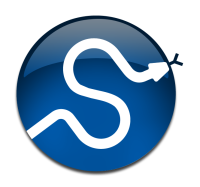

In [2]:
url = 'https://docs.scipy.org/doc/scipy-0.7.x/reference/_static/scipyshiny_small.png'

arr = skimage.io.imread(url)[..., :4]
img = imglyb.to_imglib(arr[:, :, np.newaxis, :3].transpose())
PIL.Image.fromarray(arr)

In [3]:
ProgressWriterConsole                   = autoclass('bdv.export.ProgressWriterConsole')
RandomAccessibleIntervalSource          = autoclass('bdv.util.RandomAccessibleIntervalSource')
BigWarp                                 = autoclass('bigwarp.BigWarp')
BigWarpInit                             = autoclass('bigwarp.BigWarpInit')
Converters                              = autoclass('net.imglib2.converter.Converters')
ColorChannelOrder                       = autoclass('net.imglib2.converter.ColorChannelOrder')
NLinearInterpolatorFactory              = autoclass('net.imglib2.interpolation.randomaccess.NLinearInterpolatorARGBFactory')
Helpers                                 = autoclass('net.imglib2.python.Helpers')
RealViews                               = autoclass('net.imglib2.realtransform.RealViews')
ThinplateSplineTransform                = autoclass('net.imglib2.realtransform.ThinplateSplineTransform')
WrappedIterativeInvertibleRealTransform = autoclass('net.imglib2.realtransform.inverse.WrappedIterativeInvertibleRealTransform')
ARGBType                                = autoclass('net.imglib2.type.numeric.ARGBType')
Views                                   = autoclass('net.imglib2.view.Views')

img_argb = imglyb.util.Views.permute(Converters.mergeARGB(img, ColorChannelOrder.RGB), 1, 0)
source   = RandomAccessibleIntervalSource(img_argb, ARGBType(), "scipy")

data = BigWarpInit.initData()
BigWarpInit.add(data, source, 0, 1, True)
BigWarpInit.add(data, source, 1, 1, False)
data.wrapUp()

big_warp = BigWarp(data, "scipy", ProgressWriterConsole())

In [4]:
kernel       = big_warp.getTransform()
transform    = ThinplateSplineTransform(kernel)
wrapped      = WrappedIterativeInvertibleRealTransform(transform)
img_argb_2D  = Views.hyperSlice(img_argb, 2, 0)
interpolated = Views.interpolate(Views.extendZero(img_argb_2D), NLinearInterpolatorFactory())
transformed  = RealViews.transformReal(interpolated, wrapped.inverse())

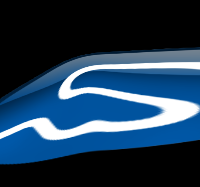

In [5]:
arr_transformed      = np.empty(arr[..., :3].shape, dtype=np.uint8)
img_transformed      = imglyb.to_imglib(arr_transformed.transpose())
img_argb_transformed = imglyb.util.Views.permute(Converters.mergeARGB(img_transformed, ColorChannelOrder.RGB), 1, 0)

Helpers                                 = autoclass('net.imglib2.python.Helpers')
Helpers.burnIn(Views.interval(Views.raster(transformed), img_argb_transformed), img_argb_transformed)
PIL.Image.fromarray(arr_transformed)